# Average proximity to kin vs. non-kin
Natalia Vélez, May 2021

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as opj
from scipy.spatial import distance
from tqdm import notebook

sns.set_style('white')
sns.set_context('talk')

Connect to database:

In [2]:
keyfile = '../6_database/credentials.key'
creds = open(keyfile, "r").read().splitlines()
myclient = pymongo.MongoClient('134.76.24.75', username=creds[0], password=creds[1], authSource='ohol') 
db = myclient.ohol

print(db)
print(db.list_collection_names())

Database(MongoClient(host=['134.76.24.75:27017'], document_class=dict, tz_aware=False, connect=True, authsource='ohol'), 'ohol')
['tfidf_matrix.files', 'maplogs', 'item_embeddings', 'tech_tree', 'lifelogs', 'objects', 'expanded_transitions', 'transitions', 'tfidf_matrix.chunks', 'avatar_embeddings', 'activity_matrix.files', 'activity_matrix.chunks', 'cleaned_job_matrix.chunks', 'cleaned_job_matrix.files', 'activity_labels', 'categories']


Load lifelogs:

In [3]:
life_query = db.lifelogs.find({},{'_id': 0, 'player_y': 0}).sort('tBirth').limit(10000) # first 10,000 births
life_data = pd.DataFrame(list(life_query))
life_data = life_data.rename(columns={'player_x': 'player'}) # clean up data frame

life_data.head()

,cause_of_death,last,birthY,parent,birthX,gametime,age,deathX,deathY,tBirth,avatar,family,first,n_lives,tDeath,player
0,hunger,PEPPLER,-436,-1,1453,0.0,21.21,1442.0,-419.0,1548814222,3,time-1548814222_eve-3_name-PEPPLER,EVE,0,1.548815e+09,ba474919bfbe67b14ec6e6fd05c19f383152b1b2
1,murdered,NaN,-436,3,1453,0.0,26.40,1390.0,-436.0,1548814226,4,time-1548814222_eve-3_name-PEPPLER,SLY,0,1.548816e+09,0c1781b6944db9e58b5d71adfe64af09fedad796
2,murdered,ARK,-395,-1,1366,0.0,39.76,1388.0,-435.0,1548814227,5,time-1548814227_eve-5_name-ARK,EVE,0,1.548816e+09,77a67da50b453a570d1e3311a56cd9da89187cd2
3,hunger,ARK,-395,5,1366,0.0,6.46,1438.0,-435.0,1548814231,6,time-1548814227_eve-5_name-ARK,FOX,0,1.548815e+09,ae87cea72e02d701fbb807b56113e3f7a3d20b83
4,hunger,ISA,-393,-1,1438,0.0,31.72,1393.0,-435.0,1548814254,9,time-1548814254_eve-9_name-ISA,EVE,0,1.548815e+09,bace3e725c1df1ef26d5bacd43b0e465eed81bb5


## Detect contemporaries

This method finds everyone that was alive at a given point and their locations of birth.
Note: in the future, we can combine data from the maplogs to get each contemporary's last known location, rather than their birth location. (Individuals might drift substantially over a lifetime.)

In [4]:
def living_pop(t):
    return life_data[(life_data['tBirth'] <= t) & (life_data['tDeath'] > t)]

Average distance to kin and non-kin:

In [5]:
def get_avg_distance(row):
    # get time of avatar's birth
    avatar = row.avatar
    avatar_birth = row.tBirth
    avatar_fam = row.family


    # find all of the avatar's contemporaries
    contemporaries = living_pop(avatar_birth)
    contemporaries = contemporaries[contemporaries.avatar != avatar] # exclude self

    if contemporaries.empty:
        # skip if there are no contemporaries
        avg_distance = pd.DataFrame(columns=['kin', 'distance', 'avatar'])
    else:
        # compute distance to kin and non-kin
        contemporaries['kin'] = np.where(contemporaries['family'] == avatar_fam, 'Kin', 'Non-kin')
        contemporaries['distance'] = contemporaries.apply(lambda c: distance.euclidean((row.birthX, row.birthY),
                                                                                       (c.birthX, c.birthY)), axis=1)

        # average distance
        avg_distance = contemporaries.groupby('kin')['distance'].agg('mean').reset_index()
        avg_distance['avatar'] = avatar

    return avg_distance

Iterate over rows:

In [6]:
dist_list = []
for idx,row in notebook.tqdm(life_data.iterrows(), total = life_data.shape[0]):
    d = get_avg_distance(row)
    dist_list.append(d)

  0%|          | 0/10000 [00:00<?, ?it/s]

Use log distance:

In [7]:
dist_df = pd.concat(dist_list)
dist_df['distance'] = dist_df['distance'] + 1
dist_df['log_distance'] = np.log10(dist_df['distance'])
dist_df.head()

,kin,distance,avatar,log_distance
0,Kin,1.000000,4,0.000000
0,Non-kin,97.176920,5,1.987563
0,Kin,1.000000,6,0.000000
1,Non-kin,97.176920,6,1.987563
0,Non-kin,59.784481,9,1.776588


Compare distance to kin and non-kin:

/n/home15/nvelezalicea/.conda/envs/ohol_py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


[Text(0.5, 0, ''),
 Text(0, 0.5, 'Avg. distance\nto contemporaries'),
 [Text(0, -2.0, '$10^{-2}$'),
  Text(0, 0.0, '$10^{0}$'),
  Text(0, 2.0, '$10^{2}$'),
  Text(0, 4.0, '$10^{4}$'),
  Text(0, 6.0, '$10^{6}$'),
  Text(0, 8.0, '$10^{8}$'),
  Text(0, 10.0, '$10^{10}$')]]

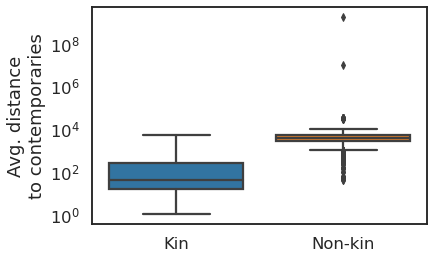

In [8]:
ax = sns.boxplot(x='kin', y='log_distance', data=dist_df)
orig_y = ax.get_yticks()
ax.set(xlabel = '', ylabel='Avg. distance\nto contemporaries',
       yticklabels = ['$10^{%i}$' % y_i for y_i in orig_y])

Save to file:

In [9]:
dist_df.to_csv('outputs/average_distance.csv', index=False)